Jupyter notebook for compression and quantization of a Pytorch model generated by AutoGluon. Using pytorch's quantization

It didn't work properly and we obtained bad results. It is because autogluon adds new features internally when generating the model and the conversion of that model to any other type, including when it is quantized, doesn't work. Because the model expects more inputs features, that can only be obtained by feeding the dataset to the predictor.pkl generated by autogluon.


Python version: 3.10.12
The requirements of versions and packages are in tiny_model/requirements.txt

Import necessary libraries

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.quantization as quant
from torch.quantization import quantize_dynamic, QuantStub, DeQuantStub
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from autogluon.tabular import TabularPredictor

Quantized model wrapper

In [4]:
class QuantizedModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(QuantizedModelWrapper, self).__init__()
        self.model = model
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model(x)
        x = self.dequant(x)
        return x

Custom Pytorch model with detailed debugging of the architecture

In [5]:
class CustomModel(torch.nn.Module):
    def __init__(self, model):
        super(CustomModel, self).__init__()
        self.model = model

    def forward(self, x):
        print(f"Initial input shape: {x.shape}")
        for name, layer in self.model.named_children():
            x = layer(x)
            print(f"After layer {name}: {x.shape}")
            if isinstance(layer, torch.nn.BatchNorm1d):
                print(f"BatchNorm layer {name} expects {layer.running_mean.shape[0]} features.")
        return x

Function to evaluate the original model

In [6]:
def evaluate_model(predictor, X, y):
    y_pred = predictor.predict(X)
    accuracy = accuracy_score(y, y_pred)
    return accuracy

Function to evaluate quantized model

In [7]:
def evaluate_quantized_model(model, X, y):
    model.eval()
    with torch.no_grad():
        X = X.unsqueeze(0)  # Add batch dimension
        X = torch.quantize_per_tensor(X, scale=1.0, zero_point=0, dtype=torch.quint8)
        y_pred = model(X.dequantize())
        y_pred = y_pred.squeeze(0)  # Remove batch dimension
    accuracy = accuracy_score(y.cpu().numpy(), y_pred.argmax(dim=1).cpu().numpy())
    return accuracy

Dynamic quantization

In [8]:
def quantize_model_dynamic(model):
    if torch.backends.quantized.engine == 'none':
        if os.name == 'posix':
            torch.backends.quantized.engine = 'qnnpack'
        else:
            torch.backends.quantized.engine = 'fbgemm'
    model_quantized = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
    return QuantizedModelWrapper(model_quantized)

Main Function parameters and paths to files and directories


In [9]:
# Main function parameters
model_directory = './datasets/CICIDS2017/balanced_binary/automl_search/models/NeuralNetTorch/a7a36c5f'  # Modify as needed
output_directory = './datasets/CICIDS2017/balanced_binary/compressed_models'  # Modify as needed
test_data_path = './datasets/CICIDS2017/balanced_binary/test.csv'  # Modify as needed
show_architecture = 'no'  # 'yes' or 'no'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
model_name = os.path.basename(model_directory)
predictor_path = os.path.abspath(os.path.join(model_directory, "../../../"))
compressed_model_path = os.path.abspath(os.path.join(output_directory, "compressed_models"))
os.makedirs(compressed_model_path, exist_ok=True)

Load the original model


In [12]:
# Load original model
original_predictor = TabularPredictor.load(predictor_path)
model = original_predictor._trainer.load_model(original_predictor.model_best)

Found 1 mismatches between original and current metadata:


Print the model architecture details


In [13]:
# Print the model architecture details
print(f"Model architecture:\n{model.model}")
for name, layer in model.model.named_children():
    print(f"Layer {name}: {layer}")
    if isinstance(layer, torch.nn.BatchNorm1d):
        print(f"BatchNorm layer {name} expects {layer.running_mean.shape[0]} features.")

Model architecture:
EmbedNet(
  (main_block): Sequential(
    (0): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=67, out_features=68, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.22362262612729422, inplace=False)
    (5): Linear(in_features=68, out_features=68, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.22362262612729422, inplace=False)
    (9): Linear(in_features=68, out_features=68, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.22362262612729422, inplace=False)
    (13): Linear(in_features=68, out_features=68, bias=True)
    (14): ReLU()
    (15): BatchNorm1d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Dropout(p=0.

Extract PyTorch model from AutoGluon model

In [ ]:
# Extract PyTorch model from AutoGluon model
torch_model = CustomModel(model.model)
torch_model.to(device)
torch_model.eval()

Prepare data and inputs

In [14]:
# Prepare data
test_data = pd.read_csv(test_data_path, index_col="ID")
X_test = test_data.drop(columns=['Label'])
y_test = test_data['Label']

# Ensure the test data has the correct shape
original_columns = X_test.columns
if X_test.shape[1] < 67:
    # Add zero features to match the expected input size of 67
    padding = 67 - X_test.shape[1]
    X_test = np.pad(X_test, ((0, 0), (0, padding)), 'constant', constant_values=0)
    new_columns = list(original_columns) + [f'padding_{i}' for i in range(padding)]
    X_test = pd.DataFrame(X_test, columns=new_columns, index=test_data.index)

# Convert to tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

Evaluate original model

In [16]:
# Evaluate original model
original_accuracy = evaluate_model(original_predictor, X_test, y_test)
print(f"Original Model Accuracy: {original_accuracy:.4f}")

# Load the specific neural network model
neural_net_model = original_predictor._trainer.load_model(original_predictor.model_best).model.to(device)


Original Model Accuracy: 0.9925


Display model characteristics if requested


In [17]:
# Display model characteristics if requested
if show_architecture == 'yes':
    print(f"Original Model architecture:\n{neural_net_model}\n")
    print(f"Original Model state dict keys:\n{neural_net_model.state_dict().keys()}\n")

Quantize Model and Evaluate

In [18]:
# Quantization Dynamic
print(f"**********QUANTIZATION DYNAMIC**************")
quantized_dynamic_model = quantize_model_dynamic(neural_net_model)
quantized_dynamic_model_path = os.path.join(compressed_model_path, "quantized_dynamic_model.pth")
torch.save(quantized_dynamic_model, quantized_dynamic_model_path)  # Save the entire model
print(f"Quantized Dynamic model saved at: {quantized_dynamic_model_path}\n")

# Model sizes
original_model_size = os.path.getsize(os.path.join(model_directory, "model.pkl"))
quantized_dynamic_model_size = os.path.getsize(quantized_dynamic_model_path)

print(f"Original Model Size: {original_model_size / 1024:.2f} KB")
print(f"Quantized Dynamic Model Size: {quantized_dynamic_model_size / 1024:.2f} KB")

# Load the quantized model
quantized_model = torch.load(quantized_dynamic_model_path)
quantized_model.to(device)

# Evaluate the quantized model
quantized_accuracy = evaluate_quantized_model(quantized_model, X_test_tensor, y_test_tensor)
print(f"Quantized Model Accuracy: {quantized_accuracy:.4f}")

**********QUANTIZATION DYNAMIC**************
Quantized Dynamic model saved at: /Users/carlos/Desktop/tiny_model/examples/bigdata_2023/datasets/CICIDS2017/balanced_binary/compressed_models/compressed_models/quantized_dynamic_model.pth

Original Model Size: 1011.32 KB
Quantized Dynamic Model Size: 100.96 KB


/Users/carlos/Desktop/tiny_model/.venv/lib/python3.10/site-packages/torch/_utils.py:382: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,
[W qlinear_dynamic.cpp:247] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


Quantized Model Accuracy: 0.5000


Plot results

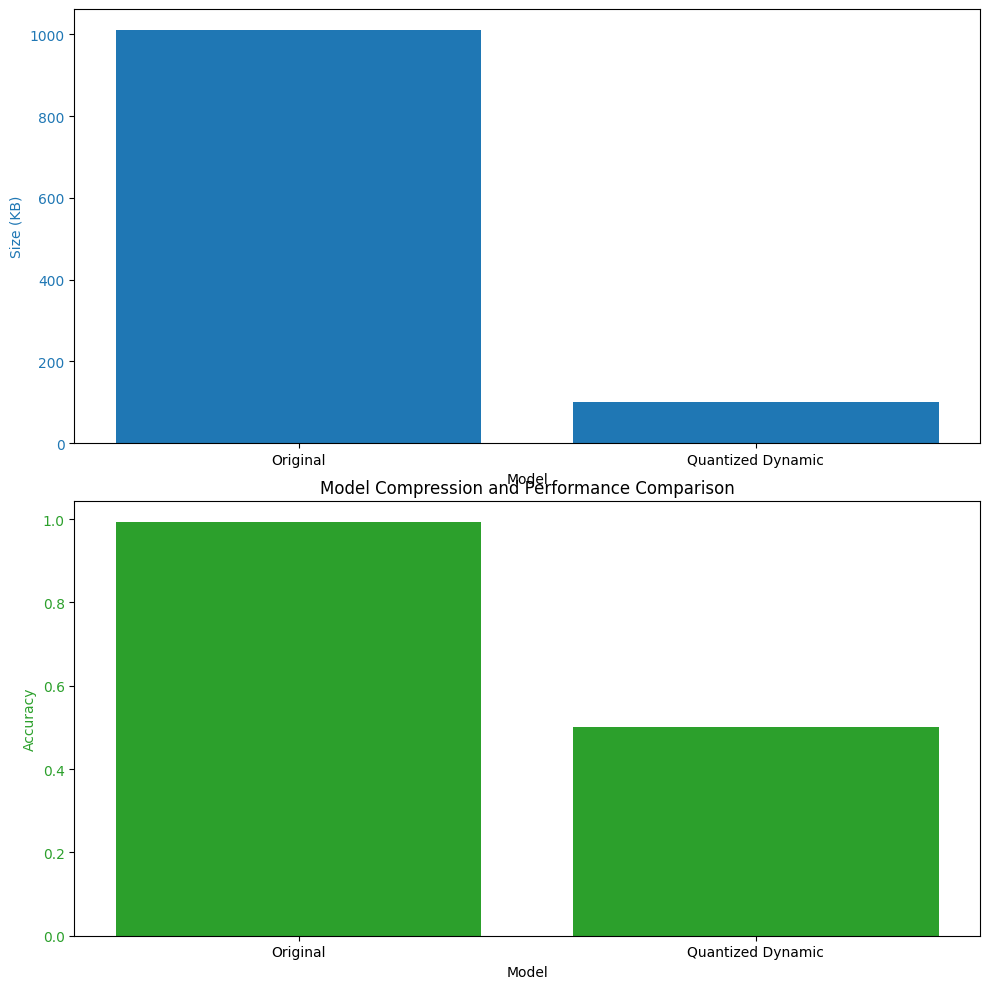

In [19]:
# Plot results
labels = ['Original', 'Quantized Dynamic']
sizes = [original_model_size, quantized_dynamic_model_size]
accuracies = [original_accuracy, quantized_accuracy]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Size (KB)', color=color)
ax1.bar(labels, [size / 1024 for size in sizes], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:green'
ax2.set_xlabel('Model')
ax2.set_ylabel('Accuracy', color=color)
ax2.bar(labels, accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Model Compression and Performance Comparison')
plt.savefig(os.path.join(output_directory, "compression_and_performance_comparison.png"))
plt.show()